## **Introduction**
The goal of this notebook is to show how trading can be automated.  provide analysis and insights that can be obtained from how to analyze and interpret historical stock prices and their plots.  I obtained the stock historical data by using the Pandas library DataReader.  DataReader is capable of reading stock APIs suchas Quandl, NASDAQ. The library provide price and volumne information regarding a stock. I will use mainly the Adjusted Closing Price. <br> 
In addition, I will examine how Long Short Term Memory (LSTM )alogorithms and SARIMA models can be used based on the Adjusted Closing Price of stock to forecast the next day price of a stock.<br>
I will analyze stocks using several key measurements.  for the following pharmaceutical companies that are developing a COVID-19 vaccine.Pfizer(PFE),Johnson & Johnson(JNJ),Moderna (MRNA), Novavax (NVAX),BioNTech SE(BNTX),MERCK & Co.(MRK)<br>
<br>
This notebook will concentrate on the following technical indicators which are beneficial in automated trading.:<br>
1. Simple Moving Average 
2. Moving Average Convergence Divergence (MACD) Crossover 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model

#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from textblob import TextBlob 
from wordcloud import WordCloud 

import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


### **Single Stock Data and Plot**
The function will take as an input any of the below column.  I will utilize mainly the Adjusted Closing Price (Adj Close).  
The closing price of a stock is the price of that stock at the close of the trading day. The adjusted closing price uses the closing price as a starting point, but it also takes into account factors such as dividends, stock splits and new stock offerings to determine a value. The adjusted closing price represents a more accurate reflection of a stock's value, since distributions and new offerings can alter the closing price.<br>



In [2]:
def single_stock_data(symbol, start,end,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
 
        return df_single

    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Dataframe has 310 rows and 6 columns



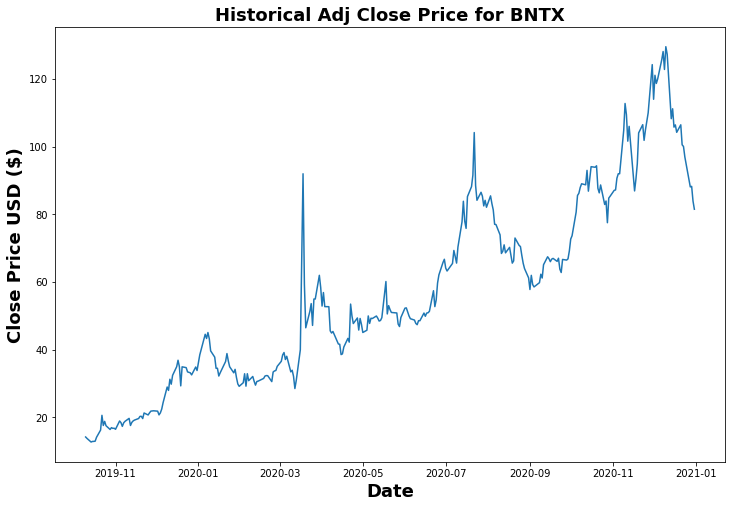

In [3]:
df_1 = single_stock_data('BNTX', start='2019',end='2021',plot=True,stock_value='Adj Close')

### **Multiple Stock Data and Plot**

In [4]:
"""
Pfizer(PFE) 
Roche(RO)  
Novartis(NOVN)
Merck(MRK)    
GlaxoSmithKline(GSK) 
Johnson & Johnson(JNJ) 

Moderna (MRNA)
Novavax (NVAX)
"""
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("Stock Adjusted Price Historical Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2019-01-02,37.603287,120.959183,39.400002,15.330000,35.559563,NaN
2019-01-03,36.551258,119.037086,40.799999,15.500000,36.058155,NaN
2019-01-04,37.385921,121.034927,42.799999,16.959999,36.857777,NaN
2019-01-07,37.585892,120.258514,45.200001,16.270000,36.481483,NaN
2019-01-08,37.759781,123.051704,46.000000,16.950001,35.870007,NaN
...,...,...,...,...,...,...
2020-12-24,36.868916,152.470001,129.339996,123.389999,48.520000,96.959999
2020-12-28,36.423756,153.190002,116.849998,111.400002,49.380001,88.110001
2020-12-29,36.651279,154.139999,120.269997,114.389999,49.900002,88.279999


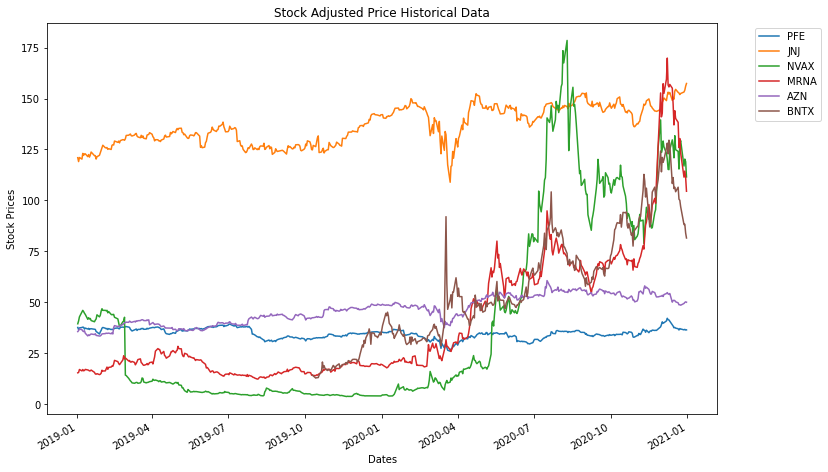

In [5]:
df_1 = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2019',end='2021',plot=True, stock_value='Adj Close')
df_1

### **Rolling Means (or Moving Averages)**
Why is rolling mean used?  Rolling mean (or moving averages) are used to smooth out short-term fluctuations in time series data and highlight long-term trends.  The rolling mean smooths out price data by creating a constantly updated average price.<br>
Each datapoint in the moving average column will be calculated on 30 items in the Adj Close column.  The moving average smoothes out the variations in the dataset.

In [6]:
df_data = single_stock_data('PFE', start='2019',end='2021',plot=False,stock_value='Adj Close')

Dataframe has 505 rows and 6 columns



In [7]:
df_data['Adj_Close_Price_30'] = df_data['Adj Close'].rolling(window=30).mean()
df_data['Adj_Close_Price_100'] = df_data['Adj Close'].rolling(window=100).mean()
df_data

,High,Low,Open,Close,Volume,Adj Close,Adj_Close_Price_30,Adj_Close_Price_100
Date,,,,,,,,
2019-01-02,41.271347,40.455406,40.910816,41.034157,26430315.0,37.603287,NaN,NaN
2019-01-03,41.119545,39.800758,41.024670,39.886147,28503533.0,36.551258,NaN,NaN
2019-01-04,41.129032,40.094875,40.265656,40.796963,27145348.0,37.385921,NaN,NaN
2019-01-07,41.385201,40.664139,40.863377,41.015179,20995469.0,37.585892,NaN,NaN
2019-01-08,41.461102,40.939278,41.328274,41.204933,19677231.0,37.759781,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-24,37.570000,37.180000,37.400002,37.270000,14790100.0,36.868916,37.840841,35.532840
2020-12-28,37.580002,36.680000,37.360001,36.820000,26993700.0,36.423756,37.880207,35.539876
2020-12-29,37.200001,36.790001,36.900002,37.049999,23152100.0,36.651279,37.893681,35.550860


In [8]:
def plot_rolling_mean(df_data, col=None,col30=None,col100=None):
    plt.figure(figsize=(12,6))
    df_data[col].plot(label='Adj Close')
    df_data[col30].plot(label='Pfizer_30')
    df_data[col100].plot(label='Pfizer_100')
    plt.ylabel("Stock Price")
    plt.legend();

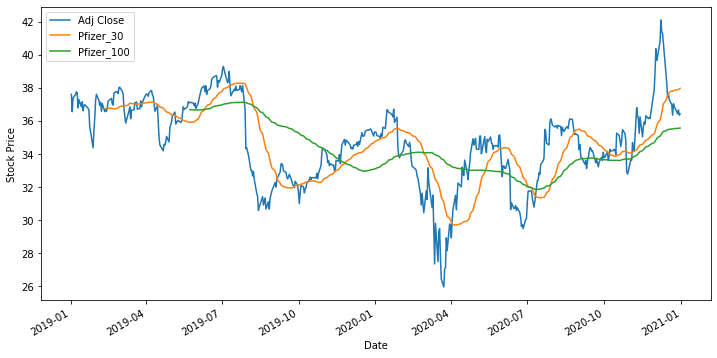

In [9]:
rolling_multi = plot_rolling_mean(df_data, col='Adj Close', col30='Adj_Close_Price_30',col100='Adj_Close_Price_100')
rolling_multi

### Simple Daily return 
Simple daily return for each stock. 1 is for 1 day.

In [10]:
sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='2021',plot=False, stock_value='Adj Close')
sdr

Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,104.081535,25.400000,NaN,23.886580,NaN
2017-01-04,26.887548,103.910828,26.200001,NaN,24.076221,NaN
2017-01-05,27.146002,104.998009,26.400000,NaN,24.731359,NaN
2017-01-06,27.041008,104.494850,27.400000,NaN,24.507233,NaN
2017-01-09,27.032928,104.476868,28.400000,NaN,24.593435,NaN
...,...,...,...,...,...,...
2020-12-24,36.868916,152.470001,129.339996,123.389999,48.520000,96.959999
2020-12-28,36.423756,153.190002,116.849998,111.400002,49.380001,88.110001
2020-12-29,36.651279,154.139999,120.269997,114.389999,49.900002,88.279999


In [11]:
(36.551258/37.60328) - 1

-0.02797686797534682

In [12]:
d_simple_returns = sdr.pct_change(1)
d_simple_returns

Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008788,-0.001640,0.031496,NaN,0.007939,NaN
2017-01-05,0.009612,0.010463,0.007634,NaN,0.027211,NaN
2017-01-06,-0.003868,-0.004792,0.037879,NaN,-0.009062,NaN
2017-01-09,-0.000299,-0.000172,0.036496,NaN,0.003517,NaN
...,...,...,...,...,...,...
2020-12-24,-0.004541,0.003488,0.013239,-0.053322,-0.005126,-0.030981
2020-12-28,-0.012074,0.004722,-0.096567,-0.097172,0.017725,-0.091275
2020-12-29,0.006247,0.006201,0.029268,0.026840,0.010531,0.001929


Text(0, 0.5, 'Daily Simple Returns')

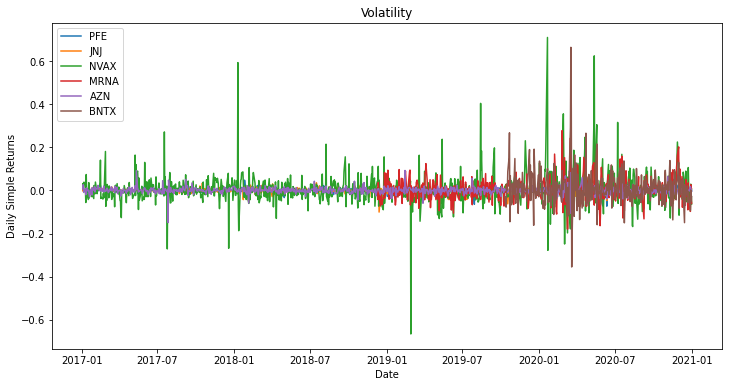

In [13]:
#visualize stocks daily returns
plt.figure(figsize=(12,6))
#loop through each stock and plot simple returns
for c in d_simple_returns.columns.values:
    plt.plot(d_simple_returns.index, d_simple_returns[c], label=c)
#plt.title(title)
#plt.ylabel(col + ' Price', fontsize=18)
plt.legend(loc='upper left', fontsize=10)
plt.title('Volatility')
plt.xlabel('Date')
plt.ylabel('Daily Simple Returns')

### Volatility
Volatility is standard deviation.  The most volatile stock is NVAX. The least volatile stock is PFE.  The higher the volatility the higher the return.  The lower the volatility the lower the return. We would expect a lower return from PFE than PFE.

In [14]:
vola = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='2021',plot=False, stock_value='Adj Close')

In [15]:
df_vol = vola.pct_change(1)
df_std = df_vol.std()
df_std

Symbols
PFE     0.014619
JNJ     0.013356
NVAX    0.074959
MRNA    0.052680
AZN     0.016553
BNTX    0.082804
dtype: float64

In [16]:
# #visualize stocks daily returns
# plt.figure(figsize=(12,6))
# #loop through each stock and plot simple returns
# for c in df_std.columns.values:
#     plt.plot(df_std.index, df_std[c], label=c)
# #plt.title(title)
# #plt.ylabel(col + ' Price', fontsize=18)
# plt.legend(loc='upper left', fontsize=10)
# plt.title('Volatility')
# plt.xlabel('Date')
# plt.ylabel('Daily Simple Returns')

In [17]:
from datetime import datetime

In [18]:
stockSymbols = ['PFE','JNJ','NVAX','MRNA','AZN']
stockStartDate='2017-01-01'
today= datetime.today().strftime('%Y-%m-%d')

def getMyPortfolio(stocks=stockSymbols,start=stockStartDate, end=today,col='Adj Close'):
    data = {}
    for stock in stockSymbols:
        data = web.DataReader(stocks,'yahoo',start,end)[col]
    
    return data

In [19]:
my_stocks = getMyPortfolio(stockSymbols)
my_stocks

Symbols,PFE,JNJ,NVAX,MRNA,AZN
Date,,,,,
2017-01-03,26.653324,104.081535,25.400000,NaN,23.886580
2017-01-04,26.887548,103.910828,26.200001,NaN,24.076221
2017-01-05,27.146002,104.998009,26.400000,NaN,24.731359
2017-01-06,27.041008,104.494850,27.400000,NaN,24.507233
2017-01-09,27.032928,104.476868,28.400000,NaN,24.593435
...,...,...,...,...,...
2021-02-03,34.840000,160.500000,284.209991,165.860001,50.000000
2021-02-04,34.889999,161.990005,280.920013,173.309998,50.360001
2021-02-05,34.919998,164.449997,290.179993,176.240005,49.730000


In [20]:
#plt.figure(figsize=(12,6))
#loop through and plot simple returns

In [21]:
#function to visualize
def showGraph(stocks=stockSymbols,start=stockStartDate, end=today, col='Adj Close'):
    my_stocks = getMyPortfolio(stocks=stocks ,start=start, end=end,col=col)
    
    title = 'Portfolio ' + col + 'Price History'
    plt.figure(figsize=(12,6))
    for c in my_stocks.columns.values:
        plt.plot(my_stocks[c], label=c)
    plt.title(title)
    plt.ylabel(col + ' Price', fontsize=18)
    plt.legend(my_stocks.columns.values, loc='upper left')
    #plt.show()

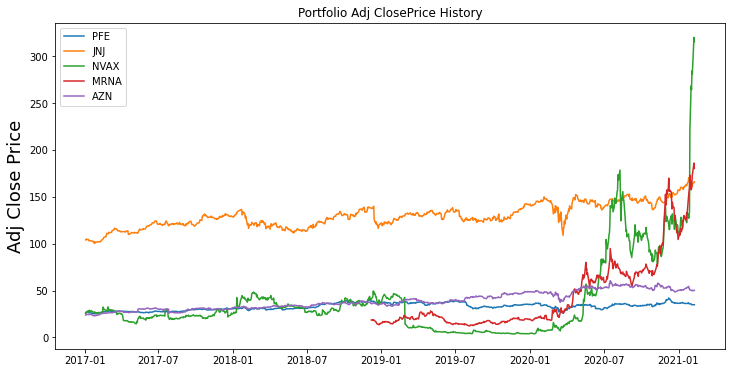

In [22]:
showGraph(stockSymbols)

In [23]:
(26.887 /26.653324)-1 

0.00876723668687629

In [24]:
#calculate simple return
#new price / old price of time period - 1
daily_simple_returns = my_stocks.pct_change(1)
#show simple returns
daily_simple_returns

Symbols,PFE,JNJ,NVAX,MRNA,AZN
Date,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008788,-0.001640,0.031496,NaN,0.007939
2017-01-05,0.009612,0.010463,0.007634,NaN,0.027211
2017-01-06,-0.003868,-0.004792,0.037879,NaN,-0.009062
2017-01-09,-0.000299,-0.000172,0.036496,NaN,0.003517
...,...,...,...,...,...
2021-02-03,-0.004287,-0.004651,0.074884,0.045907,-0.001199
2021-02-04,0.001435,0.009284,-0.011576,0.044917,0.007200
2021-02-05,0.000860,0.015186,0.032963,0.016906,-0.012510


In [25]:
daily_simple_returns = my_stocks.pct_change(1)
daily_simple_returns.std()

Symbols
PFE     0.014524
JNJ     0.013332
NVAX    0.077190
MRNA    0.052450
AZN     0.016486
dtype: float64

Text(0, 0.5, 'Daily Simple Returns')

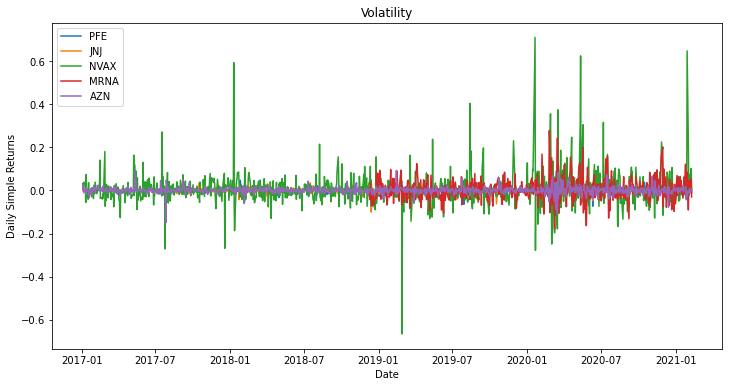

In [26]:
"""
NVAX is very volatile
MRNA is very volatile

"""
#visualize stocks daily returns
plt.figure(figsize=(12,6))
#loop through each stock and plot simple returns
for c in daily_simple_returns.columns.values:
    plt.plot(daily_simple_returns.index, daily_simple_returns[c], label=c)
#plt.title(title)
#plt.ylabel(col + ' Price', fontsize=18)
plt.legend(loc='upper left', fontsize=10)
plt.title('Volatility')
plt.xlabel('Date')
plt.ylabel('Daily Simple Returns')


The highest daily return is for MRNA which is 0.0055 daily return.  The lowest return is for PFE which has a daily return 
of .000365

In [27]:
mean_return = daily_simple_returns.mean()
print('The Daily Mean Simple Return')
mean_return

The Daily Mean Simple Return


Symbols
PFE     0.000365
JNJ     0.000542
NVAX    0.005327
MRNA    0.005506
AZN     0.000859
dtype: float64

### Rate of Return
This plot shows the percentage change in the price.  This is a good graph for a shot of what the price changes have been for the stated period.  are you looking for a stock that has had stable price changes.  It's a plot of the return centered around zero. We can see that in 2019 the price only went down below 2.5% 1 time and only went up 2.5% 1 time.<br>
We can see that around March, April 2020 the plot was very noisey.  The price several times changed above 7.5% and below 7.5%.<vr>

 Helpful for analyzing the volatility of a stock.Which stocks are more stable? If yo uwant to invest in stocks that are stable don't want volatility. Maybe yo don't want alot of risk. If you're goal of stability in the long run.

In [28]:
#df_data = single_stock_data('PFE', start='2019',end='2021',plot=False,stock_value='Adj Close')
ror = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='2021',plot=False, stock_value='Adj Close')
ror

Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,104.081535,25.400000,NaN,23.886580,NaN
2017-01-04,26.887548,103.910828,26.200001,NaN,24.076221,NaN
2017-01-05,27.146002,104.998009,26.400000,NaN,24.731359,NaN
2017-01-06,27.041008,104.494850,27.400000,NaN,24.507233,NaN
2017-01-09,27.032928,104.476868,28.400000,NaN,24.593435,NaN
...,...,...,...,...,...,...
2020-12-24,36.868916,152.470001,129.339996,123.389999,48.520000,96.959999
2020-12-28,36.423756,153.190002,116.849998,111.400002,49.380001,88.110001
2020-12-29,36.651279,154.139999,120.269997,114.389999,49.900002,88.279999


In [29]:
df_data = single_stock_data('PFE', start='2017',end='2021',plot=False,stock_value='Adj Close')

Dataframe has 1007 rows and 6 columns



In [30]:

#ror['Change'] = np.log(ror['Adj Close'] / ror['Adj Close'].shift())
ror_Change = np.log(ror / ror.shift())
ror_Change 

Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008749,-0.001641,0.031010,NaN,0.007908,NaN
2017-01-05,0.009566,0.010408,0.007605,NaN,0.026847,NaN
2017-01-06,-0.003875,-0.004804,0.037179,NaN,-0.009104,NaN
2017-01-09,-0.000299,-0.000172,0.035846,NaN,0.003511,NaN
...,...,...,...,...,...,...
2020-12-24,-0.004551,0.003482,0.013152,-0.054796,-0.005139,-0.031471
2020-12-28,-0.012148,0.004711,-0.101554,-0.102223,0.017569,-0.095712
2020-12-29,0.006227,0.006182,0.028848,0.026486,0.010476,0.001928


Text(0, 0.5, 'Daily Simple Returns')

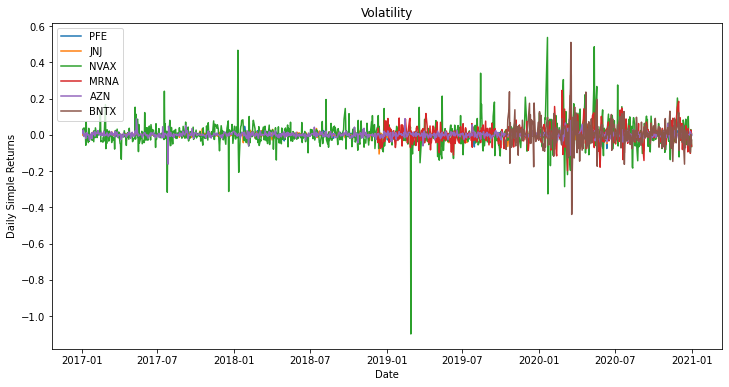

In [31]:
plt.figure(figsize=(12,6))
for c in ror_Change.columns.values:
    plt.plot(ror_Change.index, ror_Change[c], label=c)
#plt.ylabel(col + ' Price', fontsize=18)
plt.legend(loc='upper left', fontsize=10)
plt.title('Volatility')
plt.xlabel('Date')
plt.ylabel('Daily Simple Returns')

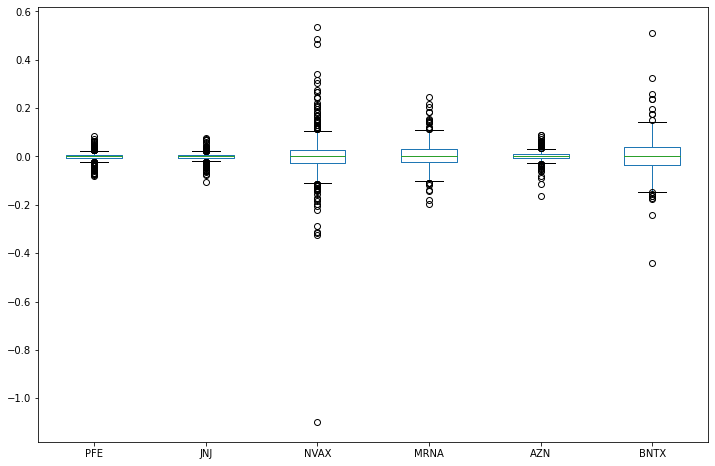

In [32]:
ror_Change.plot(kind='box', figsize=(12,8))

In [33]:
df_data['Change'] = np.log(df_data['Adj Close'] / df_data['Adj Close'].shift())
df_data

,High,Low,Open,Close,Volume,Adj Close,Change
Date,,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324,NaN
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548,0.008749
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002,0.009566
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008,-0.003875
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928,-0.000299
...,...,...,...,...,...,...,...
2020-12-24,37.570000,37.180000,37.400002,37.270000,14790100.0,36.868916,-0.004551
2020-12-28,37.580002,36.680000,37.360001,36.820000,26993700.0,36.423756,-0.012148
2020-12-29,37.200001,36.790001,36.900002,37.049999,23152100.0,36.651279,0.006227


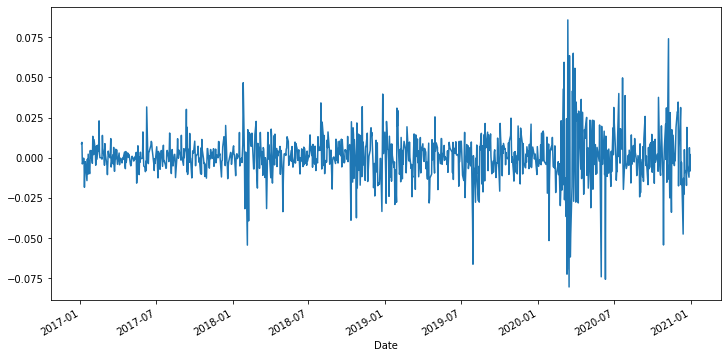

In [34]:
df_data['Change'].plot(figsize=(12,6))

### Rolling Historical Volatility
Gives us a picture of the price volatility for stated time.  The number that's usually used is 21 days because there are 21 trading days on average which 252 trading days per year. We can see that in early 2020 the price was highly volatile as compared to 2019 where there was some price changes. 

In [35]:
df_data['Volatility'] = df_data['Change'].rolling(21).std().shift()

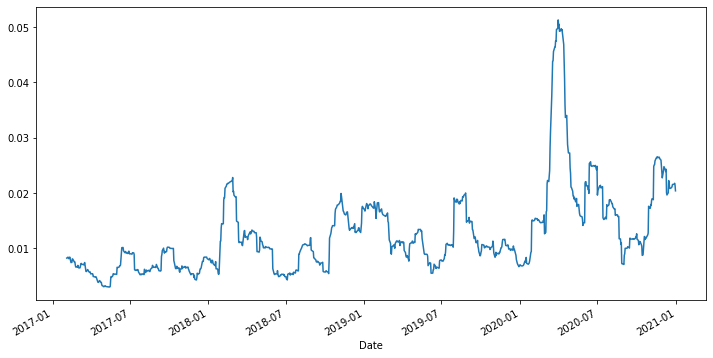

In [36]:
df_data['Volatility'].plot(figsize=(12,6));

### Volume
Volume measures the number of shares traded in a stock.  Volume can be an indicator of market strength, as rising markets on increasing volume are typically viewed as strong and healthy. When prices fall on increasing volume, the trend is gathering strength to the downside. https://www.investopedia.com <br> 
Pfizer- The plot shows that there was a big spike around in 11/20.  The data shows that on 11/9/20 there was significant volume of trading in the stock in the amount of 230,153,864 trades.  Whereas on 11/6/20 there were 23,870,676 trades. This spike in volume of trades warrants further investigation.  On 11/10/20 the volume did decrease but it was still higher than before 11/9/20 in the amount of 80,091,668.  In addition, the data shows taht that Closing Prce increased to $36.791409 from 34.163448. <br> 
<br>
On 11/9/20 we find that Pfizer posted the following tweet on twitteer
> UPDATE: We are proud to announce, along with @BioNTech_Group, that our mRNA-based #vaccine candidate has, at an interim analysis, demonstrated initial evidence of efficacy against #COVID19 in participants without prior evidence of SARS-CoV-2 infection.

Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2020-01-02,16514072.0,5777000.0,6124200.0,1233600.0,3587300.0,139500.0
2020-01-03,14922848.0,5752400.0,1709000.0,1751000.0,1208700.0,176000.0
2020-01-06,15771951.0,7731300.0,2111700.0,1606500.0,1992300.0,333300.0
2020-01-07,20108107.0,7382900.0,1024000.0,1461400.0,1871900.0,562100.0
2020-01-08,16403507.0,6605800.0,1790100.0,1041600.0,1869000.0,193900.0
2020-01-09,21971895.0,6112700.0,2095000.0,1495700.0,1959000.0,234900.0
2020-01-10,21557357.0,5042600.0,1682100.0,4504700.0,1872900.0,369100.0
2020-01-13,15392405.0,4593200.0,1766900.0,2207500.0,2395900.0,459400.0
2020-01-14,20919160.0,7037500.0,924700.0,1782800.0,2230800.0,266300.0


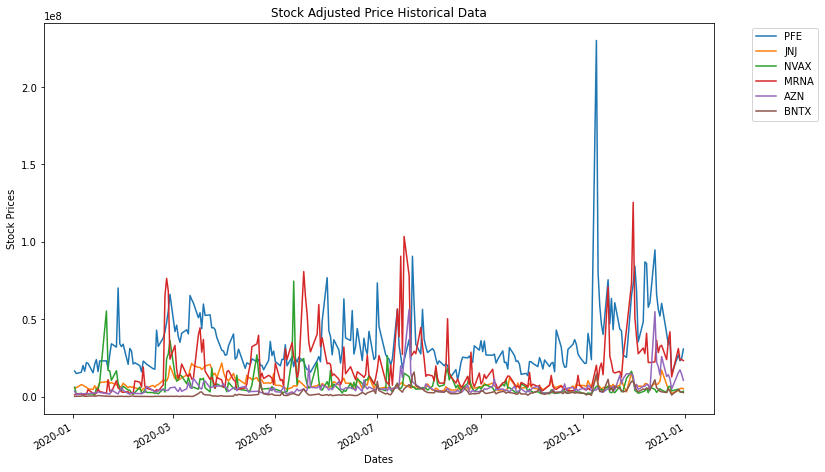

In [37]:
# vol = data_plot([['PFE','JNJ','NVAX','MRNA','AZN']], plot=True, start='2019',end='2021',stock_value='Volume')
# vol
stock_vol = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2020',end='2021',plot=True, stock_value='Volume')
pd.set_option('display.max_rows', None)
stock_vol

Dataframe has 505 rows and 6 columns



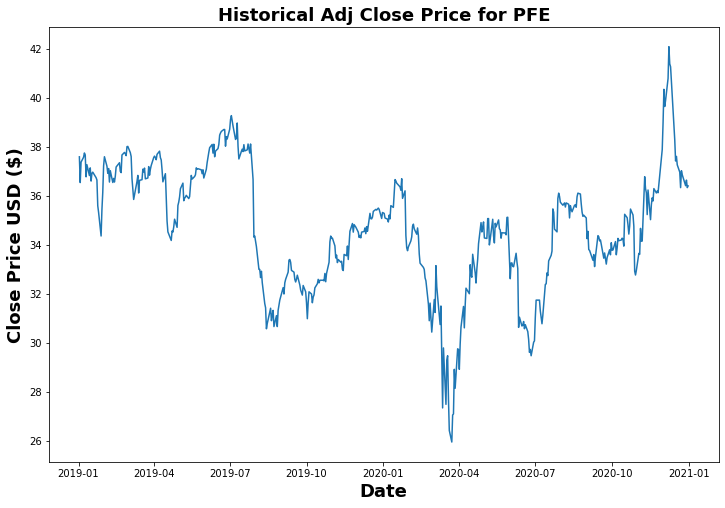

In [38]:
df_1 = single_stock_data('PFE', start='2019',end='2021',plot=True,stock_value='Adj Close')

### Market Cap
Which company might be more valuable than the other.Represent the total money traded. It's a representation of the total amount of money being traded. 

In [39]:
market_cap = web.DataReader('PFE','yahoo','2018','2021')
market_cap['Total_Traded'] = market_cap['Open'] * market_cap['Volume']
market_cap

,High,Low,Open,Close,Volume,Adj Close,Total_Traded
Date,,,,,,,
2018-01-02,34.648956,34.383301,34.516129,34.573055,17059833.0,30.589575,5.888394e+08
2018-01-03,34.886147,34.373814,34.582542,34.829224,14183151.0,30.816229,4.904894e+08
2018-01-04,35.028461,34.724857,34.829224,34.905125,13046517.0,30.883387,4.544001e+08
2018-01-05,34.990513,34.734344,34.933586,34.971539,13167517.0,30.942144,4.599886e+08
2018-01-08,34.914612,34.468693,34.838711,34.582542,19964341.0,30.597971,6.955319e+08
2018-01-09,34.762810,34.497154,34.573055,34.544594,16876226.0,30.564390,5.834627e+08
2018-01-10,34.734344,34.449715,34.478176,34.601517,18755825.0,30.614754,6.466666e+08
2018-01-11,34.819733,34.554081,34.762810,34.686909,15102555.0,30.690306,5.250072e+08
2018-01-12,34.914612,34.592030,34.753323,34.667931,20240700.0,30.673519,7.034316e+08


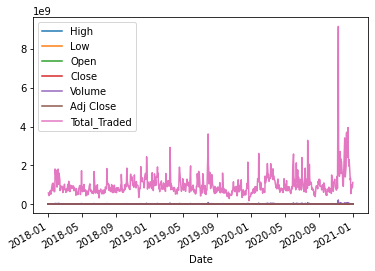

In [40]:
market_cap.plot()

In [41]:
market_cap_pfe = web.DataReader('PFE','yahoo','2018','2021')
market_cap_jnj = web.DataReader('JNJ','yahoo','2018','2021')
market_cap_nvax = web.DataReader('NVAX','yahoo','2018','2021')
market_cap_bntx = web.DataReader('BNTX','yahoo','2018','2021')
market_cap_mrna = web.DataReader('MRNA','yahoo','2018','2021')

In [42]:
market_cap_pfe['Total_Traded'] = market_cap_pfe['Open'] * market_cap_pfe['Volume']
market_cap_jnj['Total_Traded'] = market_cap_jnj['Open'] * market_cap_jnj['Volume']
market_cap_nvax['Total_Traded'] = market_cap_nvax['Open'] * market_cap_nvax['Volume']
market_cap_bntx['Total_Traded'] = market_cap_bntx['Open'] * market_cap_bntx['Volume']
market_cap_mrna['Total_Traded'] = market_cap_mrna['Open'] * market_cap_bntx['Volume']

In [43]:
market_cap_pfe.head()

,High,Low,Open,Close,Volume,Adj Close,Total_Traded
Date,,,,,,,
2018-01-02,34.648956,34.383301,34.516129,34.573055,17059833.0,30.589575,5.888394e+08
2018-01-03,34.886147,34.373814,34.582542,34.829224,14183151.0,30.816229,4.904894e+08
2018-01-04,35.028461,34.724857,34.829224,34.905125,13046517.0,30.883387,4.544001e+08
2018-01-05,34.990513,34.734344,34.933586,34.971539,13167517.0,30.942144,4.599886e+08
2018-01-08,34.914612,34.468693,34.838711,34.582542,19964341.0,30.597971,6.955319e+08


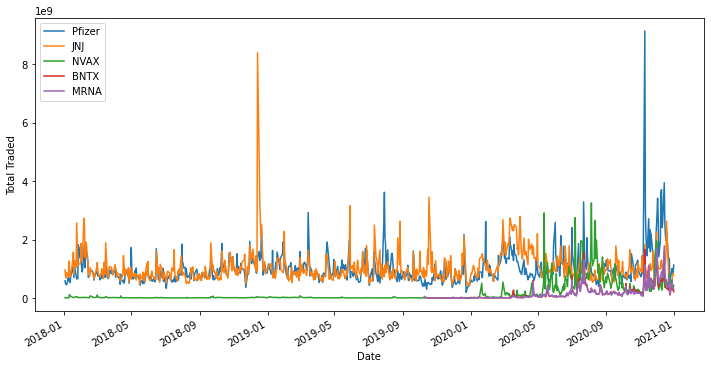

In [44]:
market_cap_pfe['Total_Traded'].plot(label='Pfizer',figsize=(12,6))
market_cap_jnj['Total_Traded'].plot(label='JNJ',figsize=(12,6))
market_cap_nvax['Total_Traded'].plot(label='NVAX',figsize=(12,6))
market_cap_bntx['Total_Traded'].plot(label='BNTX',figsize=(12,6))
market_cap_mrna['Total_Traded'].plot(label='MRNA',figsize=(12,6))
plt.ylabel('Total Traded')
plt.legend();

In [45]:
"""
looks like there was lots of $ traded for Pfizer around 12/20
"""
market_cap_pfe['Total_Traded'].argmax()

719

In [46]:
market_cap_pfe.iloc[[market_cap_pfe['Total_Traded'].argmax()]]

,High,Low,Open,Close,Volume,Adj Close,Total_Traded
Date,,,,,,,
2020-11-09,39.838711,36.413662,39.71537,37.19165,230153864.0,36.791409,9.140646e+09


### Daily Percentage Change
Not helpful for predicting future values of stock. Helpful for analyzing the volatility of a stock.Which stocks are more stable? If yo uwant to invest in stocks that are stable don't want volatility. Maybe yo don't want alot of risk. If you're goal of stability in the long run.
<br>

In [47]:
daily_change_pfe = web.DataReader('PFE','yahoo','2018','2021')
daily_change_jnj = web.DataReader('JNJ','yahoo','2018','2021')
daily_change_nvax = web.DataReader('NVAX','yahoo','2018','2021')
daily_change_bntx = web.DataReader('BNTX','yahoo','2018','2021')
daily_change_mrna = web.DataReader('MRNA','yahoo','2018','2021')

In [48]:
daily_change_pfe['returns'] = (daily_change_pfe['Close'] / daily_change_pfe['Close'].shift(1))-1 
daily_change_jnj['returns'] = (daily_change_jnj['Close'] / daily_change_jnj['Close'].shift(1))-1 
daily_change_nvax['returns'] = (daily_change_nvax['Close'] / daily_change_nvax['Close'].shift(1))-1 
daily_change_bntx['returns'] = (daily_change_bntx['Close'] / daily_change_bntx['Close'].shift(1))-1 
daily_change_mrna['returns'] = (daily_change_mrna['Close'] / daily_change_mrna['Close'].shift(1))-1 

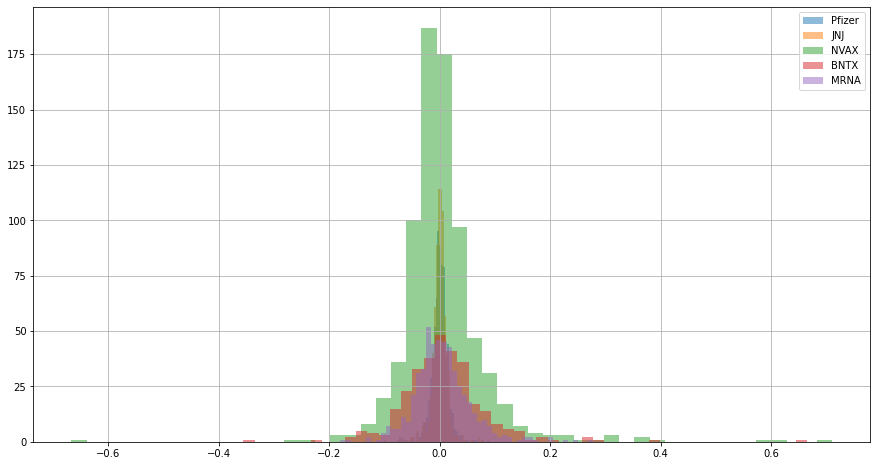

In [49]:
"""
Histogram
the fatter it is the more volatile
The higher it is the more variance we have
The higher the standard deviation is the higher the vairance is the more volatility we have
NVAX is wider than others b/c it's more volatile
"""
daily_change_pfe['returns'].hist(bins=50,label='Pfizer', alpha=0.5, figsize=(15,8)) 
daily_change_jnj['returns'].hist(bins=50, label='JNJ', alpha=0.5) 
daily_change_nvax['returns'].hist(bins=50, label='NVAX', alpha=0.5)
daily_change_bntx['returns'].hist(bins=50, label='BNTX', alpha=0.5) 
daily_change_mrna['returns'].hist(bins=50, label='MRNA', alpha=0.5)
plt.legend()

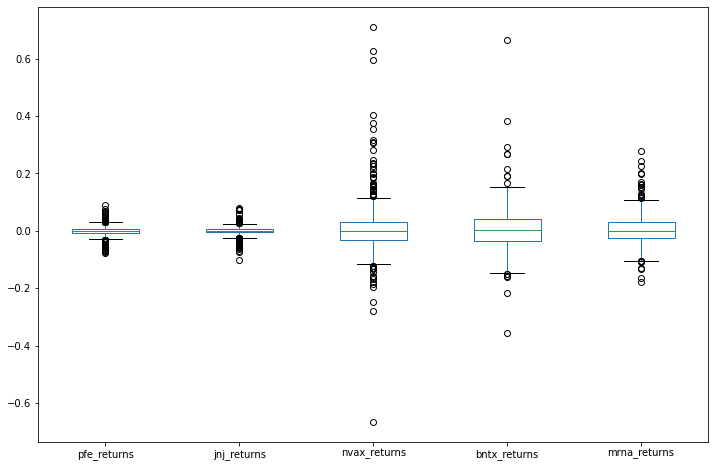

In [50]:
"""
daily percentage change or return
daily percentage change or return of nvax is spread out, so over tim period nvax seems to be more volatile
"""
box_df = pd.concat([daily_change_pfe['returns'],daily_change_jnj['returns'],daily_change_nvax['returns'],daily_change_bntx['returns'],
                       daily_change_mrna['returns']],axis=1)
box_df.columns=['pfe_returns','jnj_returns','nvax_returns','bntx_returns','mrna_returns']
box_df.plot(kind='box', figsize=(12,8))

### Cumulative Return
I invest $1 back in 2019. How much would it be worth today?

### Simple Moving Average
Simple Moving Average is one of the most common technical indicators.  SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock.<br>
The most commonly used moving averages are the 5-day, 10-day, 20-day, 50-day, and the 200-day moving averages.<br>
SMA takes hte prcie of stock over a certain number of periods and averages the price together. This is useful when trying to identify trends. Sometimres we can identify these trend changes when the SMA closing price drops over.  What this means for a ninvestor is that the closing price differes greatly frm the simple moving averageso it may be time to buy or sell as stock.<br>

### MACD (Moving Average Convergence Divergence) Crossover Strategy
This program uses the MACD Crossover to determine when to buy and ell stock.  It is technical indicator which uses the difference between exponential moving averages to determine the direction and momentum of the market. When the MACD line crosses above the signal line it's good time to buy. When the MACD line is below the signal line that's an indication of time to sell.<br>
The MACD line is calculated by taking the short term exponential moving average and subracting the long term moving average.  Usually the short term last 12 periods and the long term last 26 periods. The signal line is a 9 period exponentially smooth average of the MACD line.<br>

In [51]:
df_macd = single_stock_data('PFE', start='2019-01-01',end='2021-1-11',plot=False,stock_value='Adj Close')
df_macd

Dataframe has 511 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,41.271347,40.455406,40.910816,41.034157,26430315.0,37.603287
2019-01-03,41.119545,39.800758,41.024670,39.886147,28503533.0,36.551258
2019-01-04,41.129032,40.094875,40.265656,40.796963,27145348.0,37.385921
2019-01-07,41.385201,40.664139,40.863377,41.015179,20995469.0,37.585892
2019-01-08,41.461102,40.939278,41.328274,41.204933,19677231.0,37.759781
2019-01-09,41.432636,40.986717,41.233398,41.119545,20107580.0,37.681534
2019-01-10,41.015179,39.876659,41.005692,40.142315,39731162.0,36.786011
2019-01-11,40.683113,39.990513,40.161289,40.683113,21064506.0,37.281593
2019-01-14,40.445919,40.009487,40.370018,40.199242,17605173.0,36.838181


In [52]:
"""
program uses the 3 moving averages crossoever stategy to determine when to buy and sell stock. 
calculate 3 moving averages

"""
#calculate short term exponential moving average
shortEMA = df_macd['Adj Close'].ewm(span=12, adjust=False).mean()
#calculte long term exponential moving average
longEMA= df_macd['Adj Close'].ewm(span=26, adjust=False).mean()
#calculate the MACD and signal line indicators
#calculate MACD line
MACD = shortEMA - longEMA
#calculate signal line
signal = MACD.ewm(span=9, adjust=False).mean()

In [53]:
# #buy the stock or sell the stock
# plt.figure(figsize=(12,6))
# plt.plot(df_macd.index, MACD,label='PFE MACD', color='red')
# plt.plot(df_macd.index, signal,label='Signal line', color='blue')
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')

In [54]:
#plot shows where they cross
#when MACD crosses above the signal line it's a good time to buy
#create new column
df_macd['MACD'] = MACD
df_macd['Signal Line'] = signal
df_macd

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal Line
Date,,,,,,,,
2019-01-02,41.271347,40.455406,40.910816,41.034157,26430315.0,37.603287,0.000000,0.000000
2019-01-03,41.119545,39.800758,41.024670,39.886147,28503533.0,36.551258,-0.083923,-0.016785
2019-01-04,41.129032,40.094875,40.265656,40.796963,27145348.0,37.385921,-0.082135,-0.029855
2019-01-07,41.385201,40.664139,40.863377,41.015179,20995469.0,37.585892,-0.063846,-0.036653
2019-01-08,41.461102,40.939278,41.328274,41.204933,19677231.0,37.759781,-0.034918,-0.036306
2019-01-09,41.432636,40.986717,41.233398,41.119545,20107580.0,37.681534,-0.018097,-0.032664
2019-01-10,41.015179,39.876659,41.005692,40.142315,39731162.0,36.786011,-0.076151,-0.041361
2019-01-11,40.683113,39.990513,40.161289,40.683113,21064506.0,37.281593,-0.081232,-0.049336
2019-01-14,40.445919,40.009487,40.370018,40.199242,17605173.0,36.838181,-0.119660,-0.063400


In [55]:
#function that signals when to buy and when to sell
def buy_sell(signal):
    buy=[]
    sell=[]
    flag=-1
    
    for i in range(0, len(signal)):
        if signal['MACD'][i] > signal['Signal Line'][i]: #tells you it crossed signal line
            sell.append(np.nan)
            if flag != 1:
                buy.append(signal['Adj Close'][i])
                flag=1
            else:
                buy.append(np.nan)
        elif signal['MACD'][i] < signal['Signal Line'][i]: #tells you it crossed signal line
            buy.append(np.nan)
            if flag != 0:
                sell.append(signal['Adj Close'][i])
                flag=0
            else:
                sell.append(np.nan) 
        else: 
            buy.append(np.nan)
            sell.append(np.nan)
    
    return buy,sell       

In [56]:
#create buy and sell column
buy_sell = buy_sell(df_macd)

In [57]:
df_macd['Buy_Signal_Price'] = buy_sell[0]
df_macd['Sell_Signal_Price'] = buy_sell[1]
df_macd

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal Line,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,
2019-01-02,41.271347,40.455406,40.910816,41.034157,26430315.0,37.603287,0.000000,0.000000,NaN,NaN
2019-01-03,41.119545,39.800758,41.024670,39.886147,28503533.0,36.551258,-0.083923,-0.016785,NaN,36.551258
2019-01-04,41.129032,40.094875,40.265656,40.796963,27145348.0,37.385921,-0.082135,-0.029855,NaN,NaN
2019-01-07,41.385201,40.664139,40.863377,41.015179,20995469.0,37.585892,-0.063846,-0.036653,NaN,NaN
2019-01-08,41.461102,40.939278,41.328274,41.204933,19677231.0,37.759781,-0.034918,-0.036306,37.759781,NaN
2019-01-09,41.432636,40.986717,41.233398,41.119545,20107580.0,37.681534,-0.018097,-0.032664,NaN,NaN
2019-01-10,41.015179,39.876659,41.005692,40.142315,39731162.0,36.786011,-0.076151,-0.041361,NaN,36.786011
2019-01-11,40.683113,39.990513,40.161289,40.683113,21064506.0,37.281593,-0.081232,-0.049336,NaN,NaN
2019-01-14,40.445919,40.009487,40.370018,40.199242,17605173.0,36.838181,-0.119660,-0.063400,NaN,NaN


The blue line is price of stock. Green arrow tells us we should buy. On 7/19 tells us we should buy at around 39.00.
But before around this time we should sell at around $38.00.  After 4/2019 said to buy at $36.00 and then sell around 7/19 at 38.00. Would have amde around $2.00 per share.<br>
Around 4/20 tells us to buy at 28.00 and around 5/20 to sell at 34.00 per share.

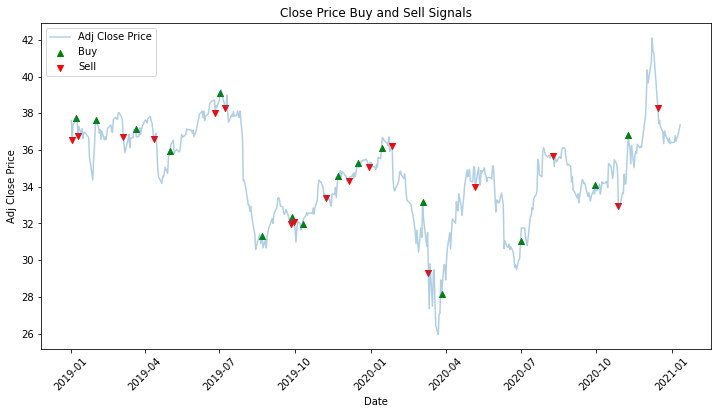

In [58]:
#blue line is actual price of PFE stock
#plot buy and sell signals
plt.figure(figsize=(12,6))
plt.scatter(df_macd.index, df_macd['Buy_Signal_Price'], color='green',label='Buy',marker='^', alpha=1)
plt.scatter(df_macd.index, df_macd['Sell_Signal_Price'], color='red',label='Sell',marker='v', alpha=1)
plt.plot(df_macd['Adj Close'], label='Adj Close Price', alpha=0.35)
plt.title('Close Price Buy and Sell Signals')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Adj Close Price')
plt.legend(loc='upper left')

## **Forecasting**
### Long Short Term Memory (LSTM)

In [59]:
def get_data(symbol, data_source,start,end):
    df = web.DataReader(symbol,data_source, start, end) 
    #print('Dataset consisits of {} and {}'.format(df[0].shape,df[1].shape))
    df_shape = df.shape
    print('Dataframe consists of {} rows and {} columns'.format(df_shape[0],df_shape[1]))
    
    plt.figure(figsize=(12,8))
    plt.plot(df['Adj Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    return df

Dataframe consists of 511 rows and 6 columns


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,15.450000,14.510000,14.930000,15.330000,2318100,15.330000
2019-01-03,16.080000,15.200000,15.490000,15.500000,1588900,15.500000
2019-01-04,17.500000,15.894000,16.000000,16.959999,1651800,16.959999
2019-01-07,17.940001,16.180000,17.540001,16.270000,1585400,16.270000
2019-01-08,17.468000,16.049999,17.350000,16.950001,1892700,16.950001
2019-01-09,17.250000,16.150000,17.200001,16.330000,1187400,16.330000
2019-01-10,16.510000,16.000000,16.360001,16.480000,487300,16.480000
2019-01-11,17.059999,16.530001,16.600000,17.000000,580600,17.000000
2019-01-14,17.059999,16.719999,17.000000,16.740000,612900,16.740000


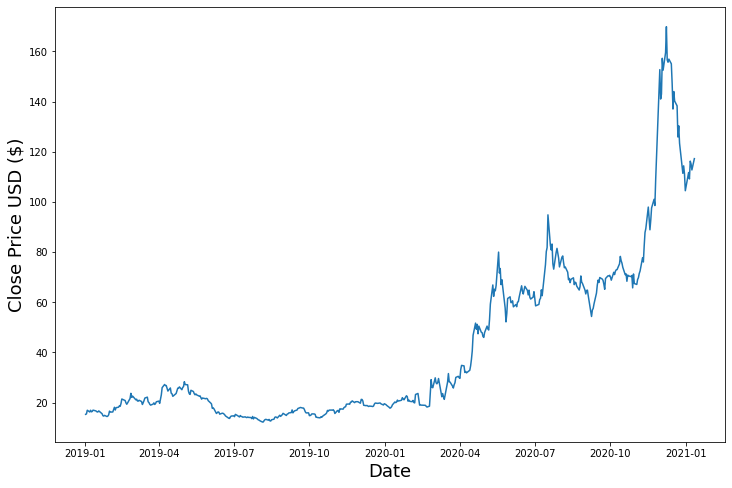

In [60]:
the_data = get_data('MRNA',data_source='yahoo', start='2019-01-01',end='2021-1-11')
the_data

In [61]:
diff_df = the_data.copy()

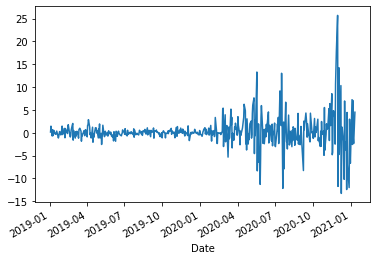

In [62]:
#change in price for day
#radio button or drop down
the_data.diff()['Adj Close'].plot()

In [63]:
diff_df['Prct_Change'] = the_data.diff().dropna()['Adj Close']

In [64]:
diff_df.head()

,High,Low,Open,Close,Volume,Adj Close,Prct_Change
Date,,,,,,,
2019-01-02,15.450000,14.510000,14.930000,15.330000,2318100,15.330000,NaN
2019-01-03,16.080000,15.200000,15.490000,15.500000,1588900,15.500000,0.170000
2019-01-04,17.500000,15.894000,16.000000,16.959999,1651800,16.959999,1.459999
2019-01-07,17.940001,16.180000,17.540001,16.270000,1585400,16.270000,-0.689999
2019-01-08,17.468000,16.049999,17.350000,16.950001,1892700,16.950001,0.680000


In [65]:
#df = pd.read_csv('data/apple_2012_1_1-2019_12_17.csv', parse_dates=True, index_col=[0])

#Get the stock quote 
#df = web.DataReader('TGT', data_source='yahoo', start='2016-01-01', end='2021-1-11') 

In [66]:
#df = df.diff().dropna() #zip_df[11226].diff().dropna()

In [67]:
def preprocessing(df,percentage):
    training_data_len = int(np.round(len(df) * percentage))
    dataset = pd.DataFrame(df)
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_data = scaler.fit_transform(dataset)
    return training_data_len, dataset, scaler, scaled_data

In [68]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df['Close'], percentage=.8)
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data['Adj Close'], percentage=.8)

In [69]:
def create_sets(training_data_len):
    #create training data set
    train_data = scaled_data[0:training_data_len,:]
    test_data = scaled_data[training_data_len -60:,:] #to 2003 which is end of dataset
    #split data into X_train and y_train data sets
    X_train = []
    y_train = []
    #create dataset X_test and y_test data sets
    X_test = []
    y_test = []    #dataset.iloc[training_data_len:, :]


    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i])
        y_train.append(train_data[i,0]) #will contain 61st value which will be at position 60

    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i,0]) 
        y_test.append(test_data[i,0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)  
    X_test = np.array(X_test) #added
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) #added
    y_test = np.array(y_test)
        
    return X_train, X_test, y_train, y_test    

In [70]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [71]:
#early_stop = EarlyStopping(monitor='val_loss', patience=2)

def create_model(X_train, y_train):
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 25))
    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.summary()
    
    return model


In [72]:

model = create_model(X_train,y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [73]:
#callbacks=[early_stop]
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop])     

Epoch 1/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0067
Epoch 2/10
349/349 [==============================] - 1s 4ms/step - loss: 0.0024
Epoch 3/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0016
Epoch 4/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 5/10
349/349 [==============================] - 3s 7ms/step - loss: 0.0014
Epoch 6/10
349/349 [==============================] - 3s 9ms/step - loss: 0.0015
Epoch 7/10
349/349 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 8/10
349/349 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 9/10
349/349 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 10/10
349/349 [==============================] - 1s 4ms/step - loss: 0.0013A: 1s - los


In [74]:
def save_model():
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [75]:
model_params = save_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [76]:
def make_prediction(model, X_test, y_test,training_data_len):
    predictions = model.predict(X_test)
    prediction_unscaled = scaler.inverse_transform(predictions) #unscaling the values
    
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)) #unscaling the values
    
    #this is in dollars
    rmse_predictions = np.sqrt(np.mean(prediction_unscaled -y_test_unscaled)**2)
    rmse_predictions
    
    predictions = pd.DataFrame(prediction_unscaled, columns=['Predictions'])
    
    train = dataset[:training_data_len]
    valid = dataset[training_data_len:] #data from index training_data_len to 
    
    valid.reset_index(inplace=True)
    valid['Prediction'] = predictions['Predictions']
    valid1 = valid.set_index('Date')
    
    plt.figure(figsize=(12,8))
    plt.title('Model')
    plt.xlabel('Label')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train['Adj Close'])
    #plt.plot(valid[['Close','Predictions']])
    plt.plot(valid1['Adj Close'])
    plt.plot(valid1['Prediction'])
    # #valid[['Close','Predictions']].plot()
    plt.legend(['Train','Valid','Predictions'],loc='lower right')
    return rmse_predictions, valid1
    

(7.879703596526501,
              Adj Close  Prediction
 Date                              
 2020-08-17   69.760002   74.706154
 2020-08-18   67.029999   74.044662
 2020-08-19   68.000000   73.365166
 2020-08-20   67.809998   72.690468
 2020-08-21   66.449997   72.037598
 2020-08-24   64.879997   71.404251
 2020-08-25   66.250000   70.776062
 2020-08-26   70.500000   70.170387
 2020-08-27   68.029999   69.652847
 2020-08-28   67.489998   69.221062
 2020-08-31   64.889999   68.862633
 2020-09-01   63.320000   68.534958
 2020-09-02   64.720001   68.198349
 2020-09-03   64.839996   67.855949
 2020-09-04   62.599998   67.515923
 2020-09-08   54.340000   67.159081
 2020-09-09   56.900002   66.681335
 2020-09-10   57.560001   66.084526
 2020-09-11   59.340000   65.399704
 2020-09-14   63.669998   64.684242
 2020-09-15   66.879997   64.033333
 2020-09-16   68.839996   63.534405
 2020-09-17   67.889999   63.242798
 2020-09-18   69.870003   63.152115
 2020-09-21   69.260002   63.259659
 2020-09

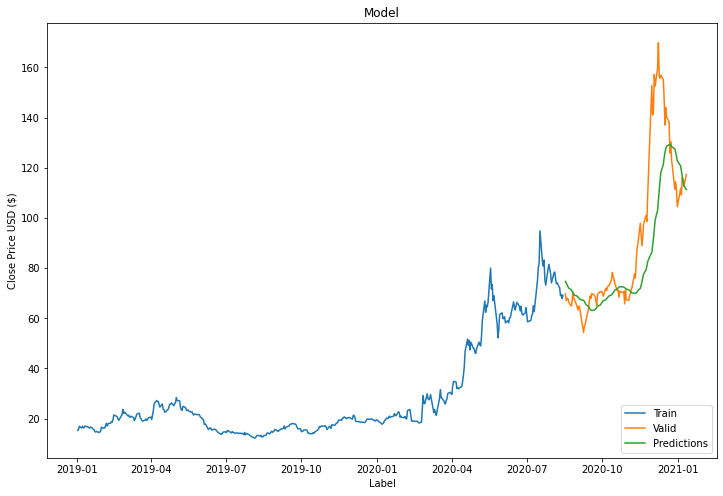

In [77]:
make_prediction(model, X_test,y_test, training_data_len )

In [78]:
from sklearn import metrics

In [79]:
"""
blue-data model was trainined on 
orange-actual closing stock price for rest of days
green-what model predcited values to be

predict closing price fo TGT stock for 2021-1-11  199.10

get the quote
"""
def get_quote(new_df):
    #get last 60days closing values and convert datframe to an array
    last_60_days = new_df[-60:].values #converts to array
    #scale data
    last_60_days_scaled = scaler.transform(last_60_days)
    #create empty list
    x_test = []
    #append last 60 days to x_test
    x_test.append(last_60_days_scaled)
    #conert x_test to a numpy array
    x_test = np.array(x_test)
    # #reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #get the predicted scaled price
    pred_price = model.predict(x_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price) 
    #what model thinks predicted price will be for 12/18/2019
    #the actual prcie was $69.94
    #DAL: 58.58, 2021-1-11 40.19
    return pred_price                    

In [80]:
get_quote(dataset)

array([[110.04926]], dtype=float32)

## New Model

Dataframe consists of 511 rows and 6 columns


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,66.849998,64.760002,65.059998,66.440002,4549300.0,63.112823
2019-01-03,66.629997,65.410004,66.129997,65.529999,4562200.0,62.248390
2019-01-04,66.879997,65.449997,66.239998,66.430000,4825900.0,63.103313
2019-01-07,69.879997,66.809998,66.809998,69.680000,7630600.0,66.190575
2019-01-08,70.480003,68.309998,70.180000,69.610001,6756000.0,66.124077
2019-01-09,70.980003,68.779999,69.379997,70.290001,6025100.0,66.770027
2019-01-10,68.330002,66.529999,67.949997,68.290001,13913700.0,64.870186
2019-01-11,70.040001,68.059998,68.300003,69.610001,5025900.0,66.124077
2019-01-14,69.849998,68.629997,69.150002,68.839996,4568000.0,65.392624


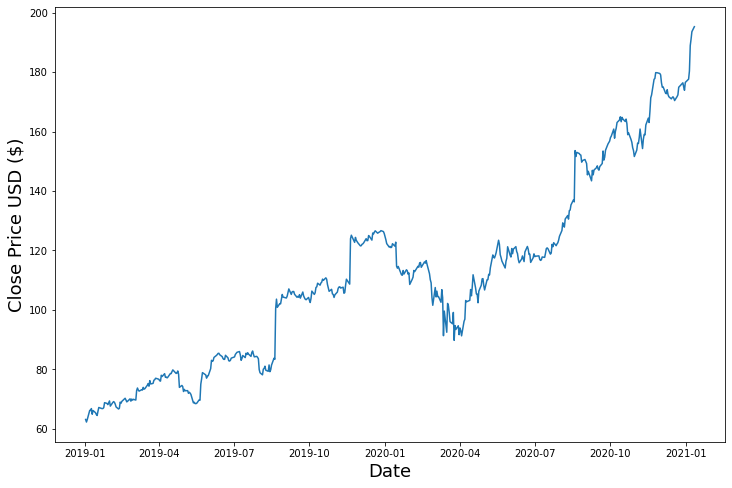

In [81]:
# the_data = get_data('AMZN',data_source='yahoo', start='2016-01-01',end='2021-1-11')
# the_data
# df_1 = get_data_plot(['AZN'], plot=True, start='2019',end='2021',stock_value='Adj Close')
# df_1
the_data_1 = get_data('TGT',data_source='yahoo', start='2019-01-01',end='2021-1-11')
the_data_1

In [82]:
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data_1['Adj Close'], percentage=.8)

In [83]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [84]:
model_params.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [85]:
#model.fit(X_train,y_train, epochs=50,batch_size=32,callbacks=[early_stop])  

(14.738037333768958,
              Adj Close  Prediction
 Date                              
 2020-08-17  136.993713  124.858627
 2020-08-18  136.336411  125.597687
 2020-08-19  153.585129  126.350830
 2020-08-20  151.613281  127.298073
 2020-08-21  152.997559  128.457794
 2020-08-24  152.609161  129.809113
 2020-08-25  152.220764  131.289871
 2020-08-26  152.081345  132.825302
 2020-08-27  149.691208  134.347137
 2020-08-28  150.229004  135.774338
 2020-08-31  150.587524  137.066727
 2020-09-01  149.930237  138.208099
 2020-09-02  149.223145  139.186905
 2020-09-03  145.428833  139.997528
 2020-09-04  146.623886  140.605652
 2020-09-08  143.407196  141.028336
 2020-09-09  146.942581  141.255768
 2020-09-10  145.438782  141.347427
 2020-09-11  147.042160  141.330231
 2020-09-14  147.828918  141.250534
 2020-09-15  148.456329  141.148254
 2020-09-16  147.380768  141.053604
 2020-09-17  147.002335  140.968796
 2020-09-18  148.207352  140.890732
 2020-09-21  149.243073  140.831680
 2020-0

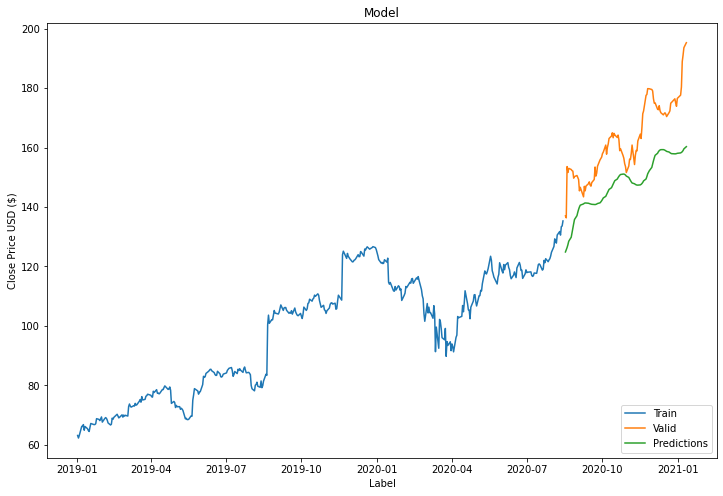

In [86]:
make_prediction(model_params, X_test,y_test, training_data_len )

In [87]:
get_quote(dataset)

array([[161.1963]], dtype=float32)

## SARIMA MODEL
A time series is a sequence where we record a metric over regular intervals.  Forecasting is the future value that this sequence will take.<br>
An ARIMA model is a forecasting algorithm that takes in previous past values to predict future values.  ARIMA models use past performance to predict future performance.  Based on its own lag and lag errors.  A SARIMA model is an ARIMA model with a seasonality component.<br>

In [88]:
"""
ARIMA is a forecasting model based on idea that information of past values may be indicative of future values.
ARIMA explains a ts based on its own past values, basically its own lags and lagged forecast errors.
"""
# df_2 = web.DataReader('MRNA','yahoo','2019','2021')
# df_2
# df_1 = get_data_plot(ticker='AMZN', start='2019',end='2021',plot=True, stock_value='Adj Close')
# df_1
# data_sarima = get_data('MRNA',data_source='yahoo', start='2019-01-01',end='2021-1-11')
# data_sarima
the_data_1

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,66.849998,64.760002,65.059998,66.440002,4549300.0,63.112823
2019-01-03,66.629997,65.410004,66.129997,65.529999,4562200.0,62.248390
2019-01-04,66.879997,65.449997,66.239998,66.430000,4825900.0,63.103313
2019-01-07,69.879997,66.809998,66.809998,69.680000,7630600.0,66.190575
2019-01-08,70.480003,68.309998,70.180000,69.610001,6756000.0,66.124077
2019-01-09,70.980003,68.779999,69.379997,70.290001,6025100.0,66.770027
2019-01-10,68.330002,66.529999,67.949997,68.290001,13913700.0,64.870186
2019-01-11,70.040001,68.059998,68.300003,69.610001,5025900.0,66.124077
2019-01-14,69.849998,68.629997,69.150002,68.839996,4568000.0,65.392624


In [89]:
#type(df_2)

In [90]:
#df_data = df_2.copy()
df_data = pd.DataFrame(the_data_1['Adj Close'])

In [91]:
df_data.head()

,Adj Close
Date,
2019-01-02,63.112823
2019-01-03,62.248390
2019-01-04,63.103313
2019-01-07,66.190575
2019-01-08,66.124077


In [92]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 511 entries, 2019-01-02 to 2021-01-11
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  511 non-null    float64
dtypes: float64(1)
memory usage: 8.0 KB


## Train Test Split

In [93]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
n = int(len(df_data) * 0.8)
train = df_data[:n]
test = df_data[n:]

In [94]:
#1265
len(train), len(test)

(408, 103)

In [95]:
train.head()

,Adj Close
Date,
2019-01-02,63.112823
2019-01-03,62.248390
2019-01-04,63.103313
2019-01-07,66.190575
2019-01-08,66.124077


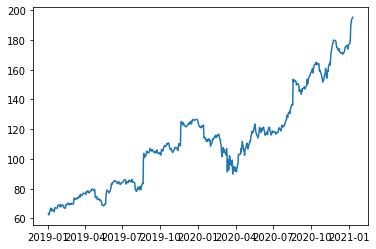

In [96]:
plt.plot(df_data.index, df_data["Adj Close"])

In [97]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [98]:
"""
Need to find optimal parameters so you can fit ARIMA model.
Forecasting using optimal parameters
"""
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [99]:
train.shape, test.shape

((408, 1), (103, 1))

In [100]:
stepwise_fit = arima_model(train['Adj Close'])

In [101]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  408
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -886.555
Date:                              Tue, 09 Feb 2021   AIC                           1789.110
Time:                                      12:26:00   BIC                           1820.961
Sample:                                           0   HQIC                          1801.728
                                              - 408                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.305      0.006      0.995      -0.596       0.599
ar.L1         -0.7482      0.084     -8.872      0.000      -0.913      -0.583
ar.L2          0.9136      0.074     12.308      0.000       0.768       1.059
ar.L3          0.8337      0.082     10.158      0.000       0.673       0.995
ma.L1          1.6768      0.093     17.968      0.000       1.494       1.860
ma.L2          0.7283      0.091      7.986      0.000       0.550       0.907
ma.S.L12      -0.9962      0.495     -2.012      0.044      -1.967      -0.026
sigma2         4.6676      2.040      2.288      0.022       0.670       8.665
===================================================================================
Ljung-Box (Q):                       40.92   Jarque-Bera (JB):              3570.34
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               4.65   Skew:                             1.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in df_data.columns:
  zip_test_2 = arima_model(df_data[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

,zipcode,pdq,seasonal_pdq,aic
0,Adj Close,"(3, 0, 0)","(0, 1, 1, 12)",2305.133576


In [103]:
import statsmodels.api as sm

In [104]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [105]:
train['Adj Close'][[0,-1]]

Date
2019-01-02     63.112823
2020-08-13    133.594620
Name: Adj Close, dtype: float64

In [106]:
test['Adj Close'][[0,-1]]

Date
2020-08-14    135.299118
2021-01-11    195.279999
Name: Adj Close, dtype: float64

In [107]:
test

,Adj Close
Date,
2020-08-14,135.299118
2020-08-17,136.993713
2020-08-18,136.336411
2020-08-19,153.585129
2020-08-20,151.613281
2020-08-21,152.997559
2020-08-24,152.609161
2020-08-25,152.220764
2020-08-26,152.081345


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  511
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1119.866
Date:                              Tue, 09 Feb 2021   AIC                           2249.732
Time:                                      12:28:03   BIC                           2270.663
Sample:                                           0   HQIC                          2257.955
                                              - 511                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8830      0.033     26.750      0.000       0.818       0.948
ar.L2          0.1912      0.044      4.391      0.000       0.106       0.277
ar.L3         -0.0716      0.037     -1.955      0.051      -0.143       0.000
ma.S.L12      -1.0000     79.197     -0.013      0.990    -156.224     154.224
sigma2         5.4329    430.376      0.013      0.990    -838.089     848.955
===================================================================================
Ljung-Box (Q):                       61.17   Jarque-Bera (JB):              4363.28
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


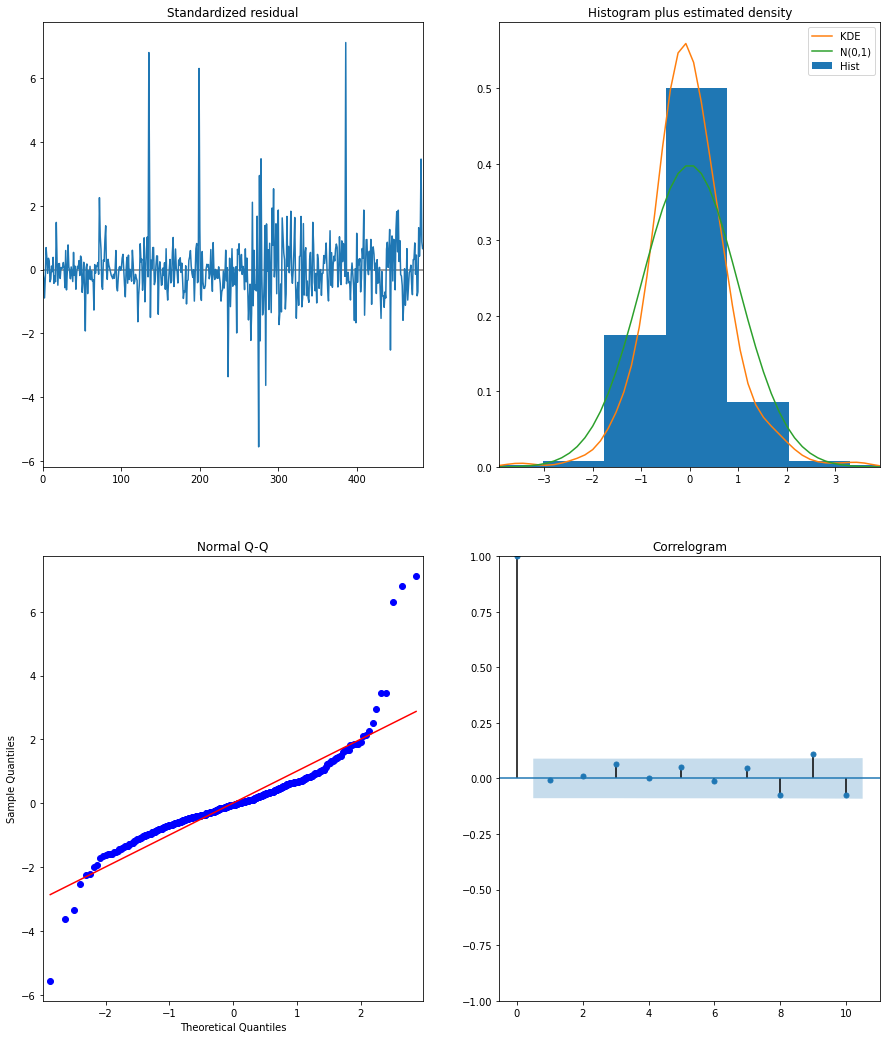

In [108]:
current_zip = 'Adj Close'
zip_params= output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

In [109]:
from matplotlib.pylab import rcParams

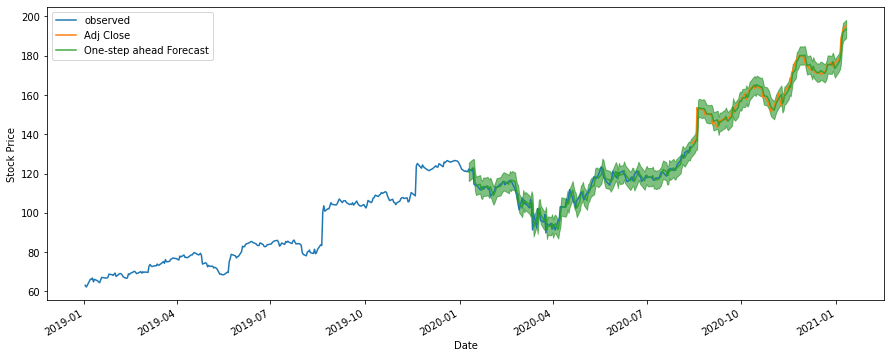

In [110]:
"""

ax = CO2['1990':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()


"""


rcParams['figure.figsize'] = 15, 6
#plt.figure(figsize=(12,5))
# Plot observed values
ax = train['Adj Close']['2019':].plot(label='observed')#
test['Adj Close']['2019':].plot()#label='Test'
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.legend()


In [111]:
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 7.06
The Root Mean Squared Error of our forecasts is 2.66


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  511
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1119.866
Date:                              Tue, 09 Feb 2021   AIC                           2249.732
Time:                                      12:28:13   BIC                           2270.663
Sample:                                           0   HQIC                          2257.955
                                              - 511                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8830      0.033     26.750      0.000       0.818       0.948
ar.L2          0.1912      0.044      4.391      0.000       0.106       0.277
ar.L3         -0.0716      0.037     -1.955      0.051      -0.143       0.000
ma.S.L12      -1.0000     79.197     -0.013      0.990    -156.224     154.224
sigma2         5.4329    430.376      0.013      0.990    -838.089     848.955
===================================================================================
Ljung-Box (Q):                       61.17   Jarque-Bera (JB):              4363.28
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


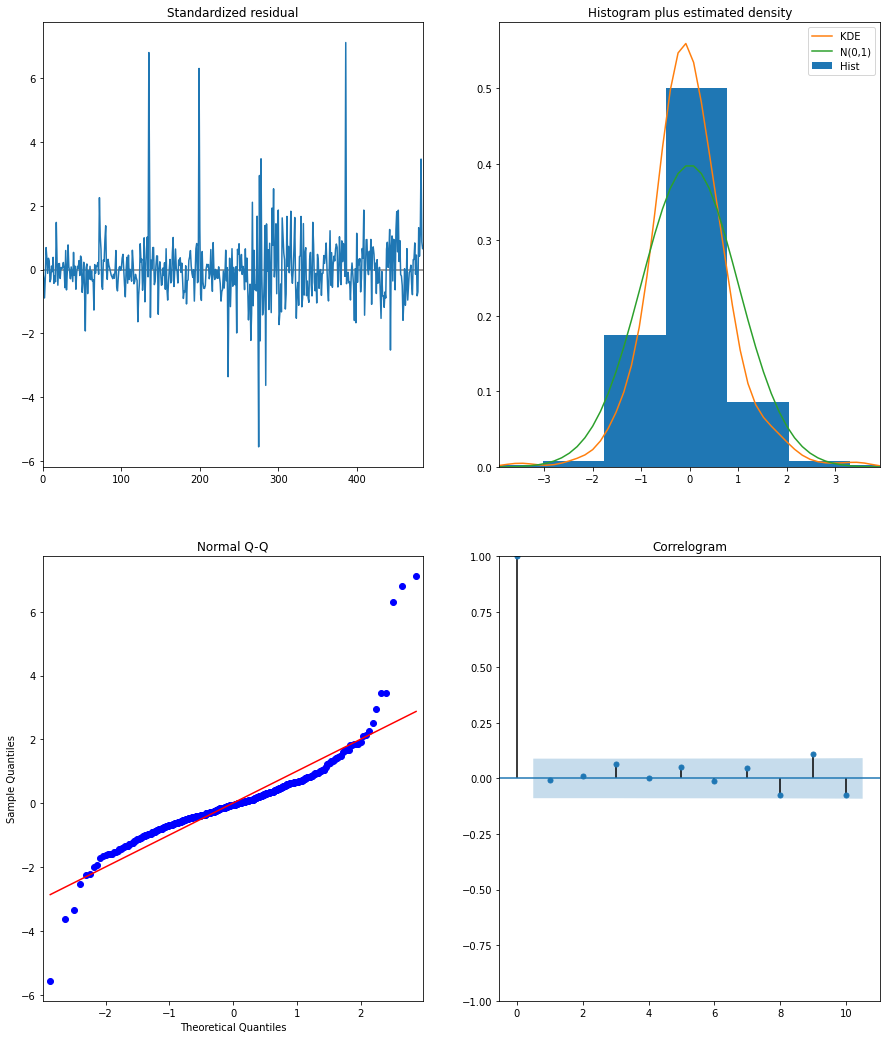

In [112]:
current_zip = 'Adj Close'
zip_params = output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [113]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Stock Price')
  plt.legend()

  return ax

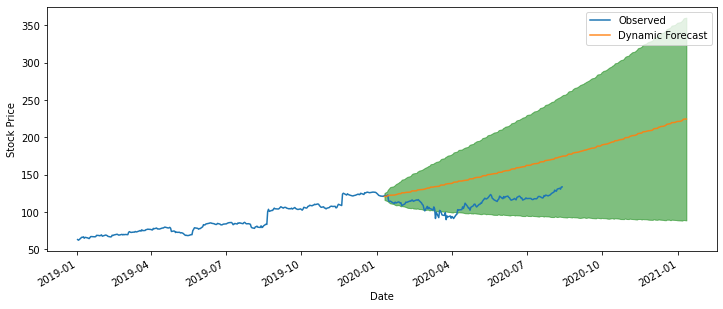

In [114]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[current_zip])
prediction_visual

In [115]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train[current_zip]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 1253.37
The Root Mean Squared Error of our forecasts is 35.4
